In [ ]:
!pip install pandas numpy matplotlib seaborn plotly wordcloud nltk scipy

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from scipy import stats

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
# Load dataset
try:
    df = pd.read_csv('student_feedback.csv')
except FileNotFoundError:
    print("Error: Please upload 'student_feedback.csv' to Colab.")
    raise



In [ ]:
# Clean column names
df.columns = df.columns.str.strip()

In [ ]:
# Define and rename rating columns
rating_columns = [
    'Well versed with the subject', 'Explains concepts in an understandable way',
    'Use of presentations', 'Degree of difficulty of assignments',
    'Solves doubts willingly', 'Structuring of the course',
    'Provides support for students going above and beyond',
    'Course recommendation based on relevance'
]
event_columns = [
    'Event Content Quality', 'Clarity of Explanations', 'Use of Visual Aids',
    'Task Difficulty', 'Doubt Resolution', 'Event Organization',
    'Support for Extra Efforts', 'Event Recommendation'
]
df.rename(columns=dict(zip(rating_columns, event_columns)), inplace=True)
rating_columns = event_columns


In [ ]:
# Handle missing/invalid data
df = df.dropna()
df[rating_columns] = df[rating_columns].apply(pd.to_numeric, errors='coerce')
df = df.dropna()
df

,Unnamed: 0,Student ID,Event Content Quality,Clarity of Explanations,Use of Visual Aids,Task Difficulty,Doubt Resolution,Event Organization,Support for Extra Efforts,Event Recommendation
0,0,340,5,2,7,6,9,2,1,8
1,1,253,6,5,8,6,2,1,2,9
2,2,680,7,7,6,5,4,2,3,1
3,3,806,9,6,7,1,5,9,4,6
4,4,632,8,10,8,4,6,6,9,9
...,...,...,...,...,...,...,...,...,...,...
996,996,55,8,7,6,2,5,7,7,9
997,997,913,5,5,6,5,6,7,6,1
998,998,199,9,5,8,3,8,1,1,2
999,999,539,10,2,7,4,3,4,10,1


In [ ]:
# Calculate average rating per response
df['Average_Rating'] = df[rating_columns].mean(axis=1)


In [ ]:
top_performers = df.nlargest(5, 'Average_Rating')[['Student ID', 'Average_Rating']]
bottom_performers = df.nsmallest(5, 'Average_Rating')[['Student ID', 'Average_Rating']]
print("\nTop 5 Performers")
print("================")
print(top_performers)
print("\nBottom 5 Performers")
print("==================")
print(bottom_performers)


Top 5 Performers
     Student ID  Average_Rating
110         188           8.250
199         770           8.250
692         238           8.250
103         671           8.125
580          78           8.125

Bottom 5 Performers
     Student ID  Average_Rating
592          54           3.375
644         281           3.375
743         724           3.500
285         450           3.625
612          73           3.625


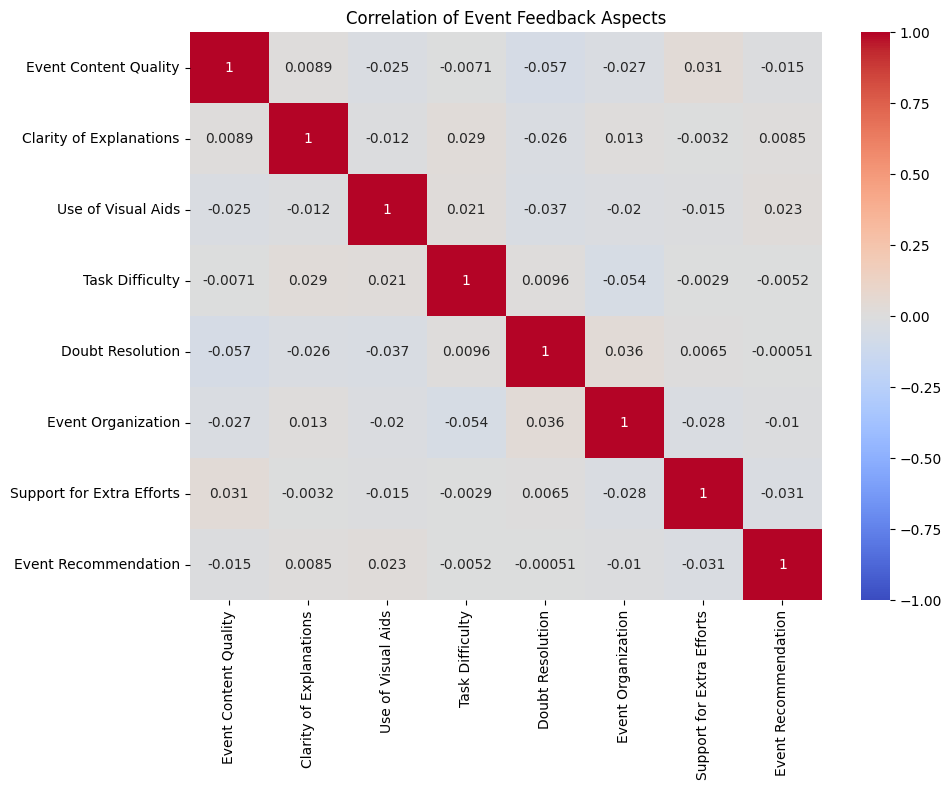

In [ ]:
plt.figure(figsize=(10, 8))
corr = df[rating_columns].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation of Event Feedback Aspects')
plt.tight_layout()
plt.savefig('correlation_heatmap.png')
plt.show()

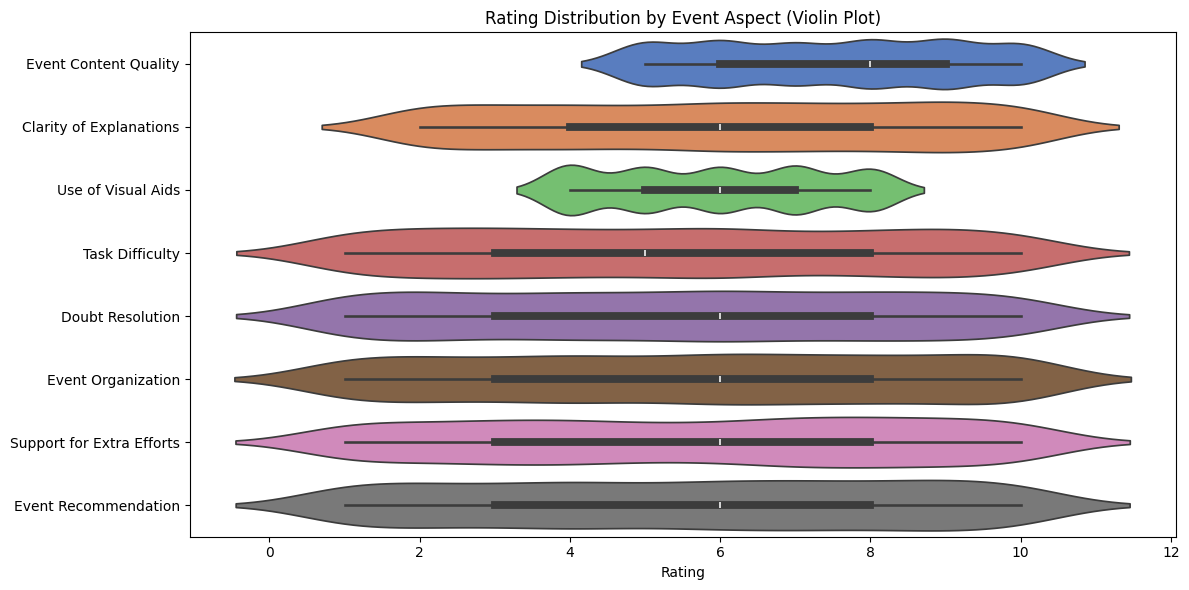

In [ ]:
plt.figure(figsize=(12, 6))
sns.violinplot(data=df[rating_columns], orient='h', palette='muted')
plt.title('Rating Distribution by Event Aspect (Violin Plot)')
plt.xlabel('Rating')
plt.tight_layout()
plt.savefig('violin_plot.png')
plt.show()

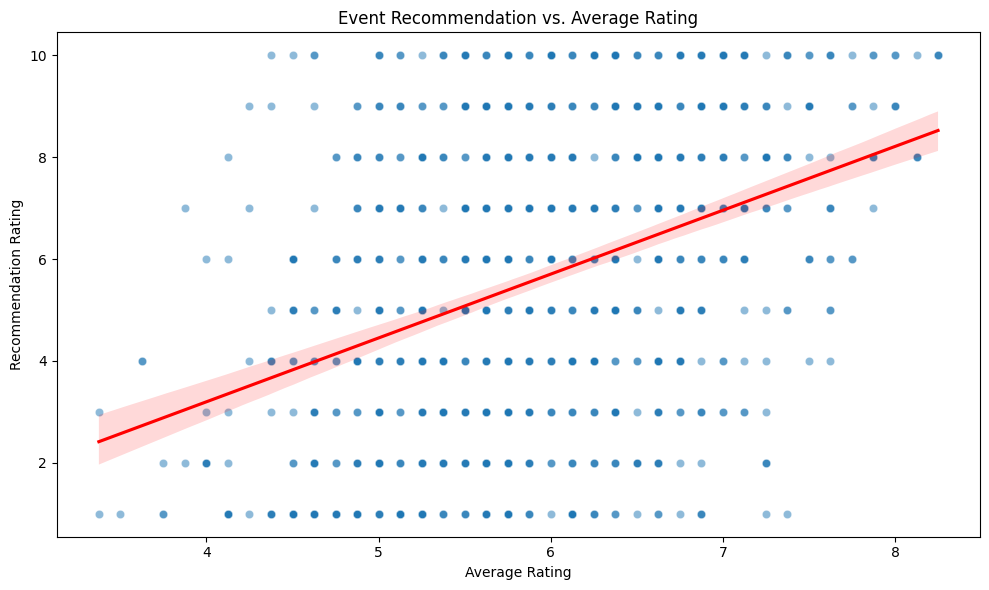

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Average_Rating', y='Event Recommendation', data=df, alpha=0.5)
sns.regplot(x='Average_Rating', y='Event Recommendation', data=df, scatter=False, color='red')
plt.title('Event Recommendation vs. Average Rating')
plt.xlabel('Average Rating')
plt.ylabel('Recommendation Rating')
plt.tight_layout()
plt.savefig('recommendation_vs_rating.png')
plt.show()

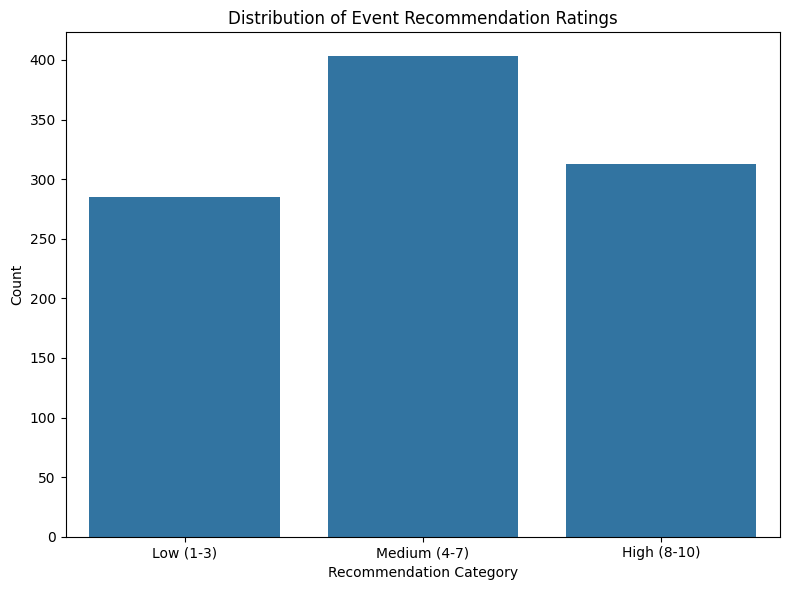

In [ ]:
df['Recommendation_Category'] = pd.cut(
    df['Event Recommendation'],
    bins=[0, 3, 7, 10],
    labels=['Low (1-3)', 'Medium (4-7)', 'High (8-10)']
)
plt.figure(figsize=(8, 6))
sns.countplot(x='Recommendation_Category', data=df)
plt.title('Distribution of Event Recommendation Ratings')
plt.xlabel('Recommendation Category')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('recommendation_distribution.png')
plt.show()

In [ ]:
fig = px.scatter_3d(
    df, x='Event Content Quality', y='Clarity of Explanations', z='Event Recommendation',
    color='Average_Rating', size='Average_Rating', opacity=0.7,
    title='3D Scatter Plot of Key Event Aspects'
)
fig.write_html('3d_scatter.html') 
fig.show()

In [ ]:
Q1 = df['Average_Rating'].quantile(0.25)
Q3 = df['Average_Rating'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['Average_Rating'] < Q1 - 1.5 * IQR) | (df['Average_Rating'] > Q3 + 1.5 * IQR)]
outlier_summary = {
    'Number of Outliers': len(outliers),
    'Outlier Student IDs': outliers['Student ID'].tolist()
}
print("Outlier Analysis")
print("===============")
for key, value in outlier_summary.items():
    print(f"{key}: {value}")

Outlier Analysis
Number of Outliers: 0
Outlier Student IDs: []


In [ ]:
rating_trends = {}
for col in rating_columns:
    high = (df[col] >= 8).mean() * 100
    medium = ((df[col] >= 4) & (df[col] < 8)).mean() * 100
    low = (df[col] <= 3).mean() * 100
    rating_trends[col] = {'High (8-10)': f"{high:.2f}%", 'Medium (4-7)': f"{medium:.2f}%", 'Low (1-3)': f"{low:.2f}%"}

print("\nRating Trends by Aspect")
print("======================")
for aspect, trends in rating_trends.items():
    print(f"{aspect}:")
    for category, value in trends.items():
        print(f"  {category}: {value}")


Rating Trends by Aspect
Event Content Quality:
  High (8-10): 51.15%
  Medium (4-7): 48.85%
  Low (1-3): 0.00%
Clarity of Explanations:
  High (8-10): 34.67%
  Medium (4-7): 43.66%
  Low (1-3): 21.68%
Use of Visual Aids:
  High (8-10): 18.28%
  Medium (4-7): 81.72%
  Low (1-3): 0.00%
Task Difficulty:
  High (8-10): 29.47%
  Medium (4-7): 39.36%
  Low (1-3): 31.17%
Doubt Resolution:
  High (8-10): 29.77%
  Medium (4-7): 40.36%
  Low (1-3): 29.87%
Event Organization:
  High (8-10): 31.77%
  Medium (4-7): 39.96%
  Low (1-3): 28.27%
Support for Extra Efforts:
  High (8-10): 32.67%
  Medium (4-7): 38.86%
  Low (1-3): 28.47%
Event Recommendation:
  High (8-10): 31.27%
  Medium (4-7): 40.26%
  Low (1-3): 28.47%


In [ ]:
p_values = pd.DataFrame(index=rating_columns, columns=rating_columns)
for col1 in rating_columns:
    for col2 in rating_columns:
        if col1 != col2:
            _, p_val = stats.pearsonr(df[col1], df[col2])
            p_values.loc[col1, col2] = p_val
        else:
            p_values.loc[col1, col2] = 1.0

significant_corrs = (p_values < 0.05).sum().sum() - len(rating_columns)
print("\nCorrelation Significance Analysis")
print("================================")
print(f"Number of significant correlations (p < 0.05): {significant_corrs}")


Correlation Significance Analysis
Number of significant correlations (p < 0.05): -8


In [ ]:
avg_ratings = df[rating_columns].mean()
summary = {
    'Total Responses': len(df),
    'Average Rating (Overall)': df['Average_Rating'].mean(),
    'Highest Rated Aspect': avg_ratings.idxmax(),
    'Highest Average Rating': avg_ratings.max(),
    'Lowest Rated Aspect': avg_ratings.idxmin(),
    'Lowest Average Rating': avg_ratings.min(),
    'Number of Outliers': len(outliers),
    'Significant Correlations': significant_corrs,
    'Areas for Improvement': (
        f"Lowest rated: '{avg_ratings.idxmin()}' ({avg_ratings.min():.2f}). Focus on improving this."
    ),
    'Strengths': (
        f"Highest rated: '{avg_ratings.idxmax()}' ({avg_ratings.max():.2f}). Strong performance here."
    )
}

with open('event_feedback_summary.txt', 'w') as f:
    f.write('Event Feedback Analysis Summary\n')
    f.write('================================\n')
    for key, value in summary.items():
        f.write(f'{key}: {value}\n')

print("\nEvent Feedback Analysis Summary")
print("================================")
for key, value in summary.items():
    print(f"{key}: {value}")


Event Feedback Analysis Summary
Total Responses: 1001
Average Rating (Overall): 5.9154595404595405
Highest Rated Aspect: Event Content Quality
Highest Average Rating: 7.497502497502498
Lowest Rated Aspect: Task Difficulty
Lowest Average Rating: 5.430569430569431
Number of Outliers: 0
Significant Correlations: -8
Areas for Improvement: Lowest rated: 'Task Difficulty' (5.43). Focus on improving this.
Strengths: Highest rated: 'Event Content Quality' (7.50). Strong performance here.
